In [ ]:
!pip install cirq

     |████████████████████████████████| 1.6MB 5.5MB/s 


$c_j^\dagger \longrightarrow \frac{1}{2} (X_j - iY_j) Z_1 \dots Z_{j-1}$


$c_j \longrightarrow \frac{1}{2} (X_j + iY_j) Z_1 \dots Z_{j-1}$

$n_j = c_j^\dagger c_j \longrightarrow \frac{1}{2} (I - Z_j)$

$c_j^\dagger c_{j+1} + h.c. \longrightarrow \frac{1}{2} (X_j X_{j+1} + Y_j Y_{j+1})$


$$H_{HDMZ} = -J \sum_{i \in L^2} n_i \cdot (n_{i+\hat{x}} + n_{i+\hat{y}}) + D \sum_i (\hat{y} \cdot n_i \times n_{i+\hat{x}} - \hat{x} \cdot n_i \times n_{i+\hat{y}}) - B \cdot \sum_i n_i$$

$$H_o = \sum_i X_i$$

In [ ]:
import itertools
import numpy as np
import networkx
import scipy.optimize
import cirq
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
def rxx(rads):
    """Returns a gate with the matrix exp(-i X⊗X rads)."""
    return cirq.XXPowGate(exponent=rads / np.pi, global_shift=-0.5)

def ryy(rads):
    """Returns a gate with the matrix exp(-i Y⊗Y rads)."""
    return cirq.YYPowGate(exponent=rads / np.pi, global_shift=-0.5)


def qaoa_unitary(n, qubits, betas, gammas, t, U, h):  # Nodes should be integers
    for beta, gamma in zip(betas, gammas):
        yield (cirq.rz(h * gamma).on(qubits[i]) for i in range(0,n,2)) #Zeeman up
        yield (cirq.rz(-h * gamma).on(qubits[i]) for i in range(1,n,2)) #Zeeman down

        yield (rxx(-0.5 * t * gamma).on(qubits[i], qubits[i+2]) for i in range(0,n-2,2)) #hopping up XX
        yield (rxx(-0.5 * t * gamma).on(qubits[i], qubits[i+2]) for i in range(1,n-2,2)) #hopping down XX
        yield (ryy(-0.5 * t * gamma).on(qubits[i], qubits[i+2]) for i in range(0,n-2,2)) #hopping up YY
        yield (ryy(-0.5 * t * gamma).on(qubits[i], qubits[i+2]) for i in range(1,n-2,2)) #hopping down YY

        yield (cirq.CZ(qubits[i], qubits[i+1])**(U * gamma / np.pi) for i in range(0,n,2)) #On-site interaction

        yield cirq.rx(beta).on_each(*qubits) #The Initial Hamiltonian

def qaoa_circuit(n, qubits, betas, gammas, t, U, h):  # Nodes should be integers
    return cirq.Circuit(
        # Prepare uniform superposition
        cirq.H.on_each(*qubits),
        # Apply QAOA unitary
        qaoa_unitary(n, qubits, betas, gammas, t, U, h),
        # Measure
        cirq.measure(*qubits, key='m'))

def Energy(bitstrings,U,h):
    res=[]
    m,n=np.shape(bitstrings)
    for i in range(m):
        E_val=0
        #Zeeman up
        for j in range(0,n,2):
            E_val-=h*bitstrings[i][j]
        #Zeeman down
        for j in range(1,n,2):
            E_val+=h*bitstrings[i][j]
        #On-site interaction
        for j in range(0,n,2):
            E_val+=U*bitstrings[i][j]*bitstrings[i][j+1]
        
        res.append(E_val)
    return res

Optimizing objective function ...


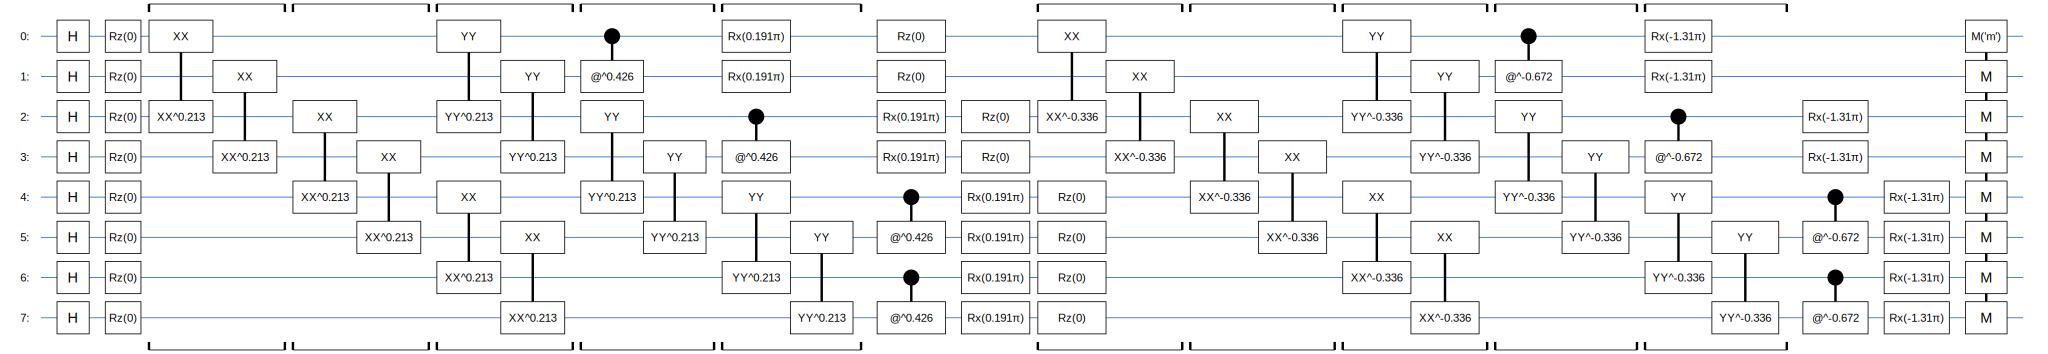

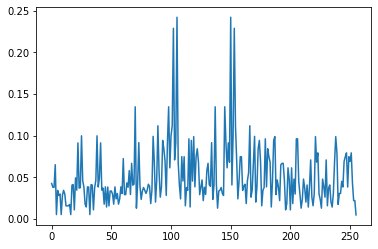

In [ ]:
repetitions=1000
maxiter=50

t=-1 #Hopping
U=1 #On-site interaction
h=0 #Magnetic field

# Set problem parameters
n = 8
p = 2 #No. of QAOA steps

# Make qubits
qubits = cirq.LineQubit.range(n)

# Create variables to store ground state
#ground_state = None
#ground_state_energy = 0

Energy_history=[]

# Initialize simulator
simulator = cirq.Simulator()

# Define objective function

def f(x):
    # Create circuit
    betas = x[:p]
    gammas = x[p:]
    circuit = qaoa_circuit(n, qubits, betas, gammas, t, U, h)
    # Sample bitstrings from circuit
    result = simulator.run(circuit, repetitions=repetitions)
    bitstrings = result.measurements['m']
    # Process bitstrings
    #global ground_state
    #global ground_state_energy
    values = Energy(bitstrings, U, h)
    '''
    max_value_index = np.argmax(values)
    max_value = values[max_value_index]
    if max_value > ground_state_energy:
        ground_state_energy = max_value
        ground_state = bitstrings[max_value_index]
    '''
    mean = np.mean(values)
    Energy_history.append(mean)
    #print(mean)
    return mean

# Pick an initial guess
x0 = np.random.uniform(-np.pi, np.pi, size=2 * p)

# Optimize f
print('Optimizing objective function ...')
res = scipy.optimize.minimize(f,
                        x0,
                        method='Nelder-Mead',
                        options={'maxiter': maxiter})

# Print an example circuit
betas = res.x[:p]
gammas = res.x[p:]
circuit = qaoa_circuit(n, qubits, betas, gammas, t, U, h)

result = simulator.simulate(circuit[:-1])
plt.plot(np.abs(result.final_state_vector))

# Print the results
#print('Ground State wave function {}.'.format(ground_state))
#print('Energy {}.'.format(ground_state_energy))

SVGCircuit(circuit)

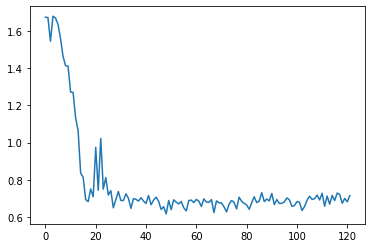

In [ ]:
plt.plot(Energy_history)

In [ ]:
gs=np.abs(result.final_state_vector)

In [ ]:
keys=np.argsort(gs)

for i in range(-1,-10,-1):
  temp=bin(keys[i])[2:]
  temp=(n-len(temp))*'0' + temp
  binary=[int(x) for x in temp]
  #if sum(binary)==n//2: 
  print(temp, "   No. of electrons: ", sum(binary), "  Amplitude:  ", gs[keys[i]])

01101001    No. of electrons:  4   Amplitude:   0.24222937
10010110    No. of electrons:  4   Amplitude:   0.24222934
10011001    No. of electrons:  4   Amplitude:   0.22896196
01100110    No. of electrons:  4   Amplitude:   0.22896196
10001001    No. of electrons:  3   Amplitude:   0.13461618
01000110    No. of electrons:  3   Amplitude:   0.13461617
10010001    No. of electrons:  3   Amplitude:   0.13461617
01100010    No. of electrons:  3   Amplitude:   0.13461615
01011001    No. of electrons:  4   Amplitude:   0.11184085
